# LSTM-based time series prediction for Toyota (7203.T) equity share price

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.stats import skew, kurtosis

In [2]:
# 1. Download historical data for Toyota (Tokyo: 7203.T)
df = yf.download('7203.T', start='2015-01-01', end='2024-06-30')
data = df[['Close']].dropna()

C:\Users\DELL\AppData\Local\Temp\ipykernel_28460\2883071115.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('7203.T', start='2015-01-01', end='2024-06-30')
[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,7203.T,7203.T,7203.T,7203.T,7203.T
Date,,,,,
2015-01-05,1108.074707,1118.111865,1094.642550,1116.635810,47576500
2015-01-06,1077.520142,1090.952206,1077.520142,1080.767481,61939500
2015-01-07,1093.313965,1104.827176,1070.877911,1071.025480,57327000
2015-01-08,1115.011963,1115.307102,1106.303203,1107.041230,50272500
2015-01-09,1123.130493,1131.543936,1116.045356,1126.230173,52127000
...,...,...,...,...,...
2024-06-24,3048.920654,3075.054260,3014.075847,3022.787049,30864600
2024-06-25,3190.235596,3200.882620,3066.342951,3096.348201,44118500


In [4]:
 def full_summary(df):
        pd.set_option('display.float_format', '{:.2f}'.format)  # Show numbers, not scientific
        stats = pd.DataFrame()
        stats['Count'] = df.count()
        stats['Mean'] = df.mean()
        stats['Median'] = df.median()
        stats['Mode'] = df.mode().iloc[0]  # if multiple modes, take the first
        stats['Std Dev'] = df.std()
        stats['Variance'] = df.var()
        stats['Min'] = df.min()
        stats['25%'] = df.quantile(0.25)
        stats['50%'] = df.quantile(0.50)
        stats['75%'] = df.quantile(0.75)
        stats['Max'] = df.max()
        stats['Skewness'] = df.apply(skew)
        stats['Kurtosis'] = df.apply(kurtosis)
        stats['Range'] = df.max() - df.min()
        stats['Sum'] = df.sum()
        stats['Unique'] = df.nunique()
        stats['Missing'] = df.isnull().sum()

        return stats.T  # Transpose for better layout

full_summary(df)

Price,Close,High,Low,Open,Volume
Ticker,7203.T,7203.T,7203.T,7203.T,7203.T
Count,2341.00,2341.00,2341.00,2341.00,2341.00
Mean,1476.84,1489.31,1464.36,1476.82,33000600.90
Median,1226.87,1235.05,1219.78,1227.18,29105000.00
Mode,1171.79,1171.79,1171.79,1171.79,0.00
Std Dev,584.85,591.92,577.50,585.18,16733985.00
Variance,342055.04,350373.90,333510.63,342436.58,280026254033276.94
Min,769.26,781.63,760.29,780.86,0.00
25%,1116.26,1124.61,1107.92,1116.64,21969700.00
50%,1226.87,1235.05,1219.78,1227.18,29105000.00


Text(0, 0.5, 'Share Price')

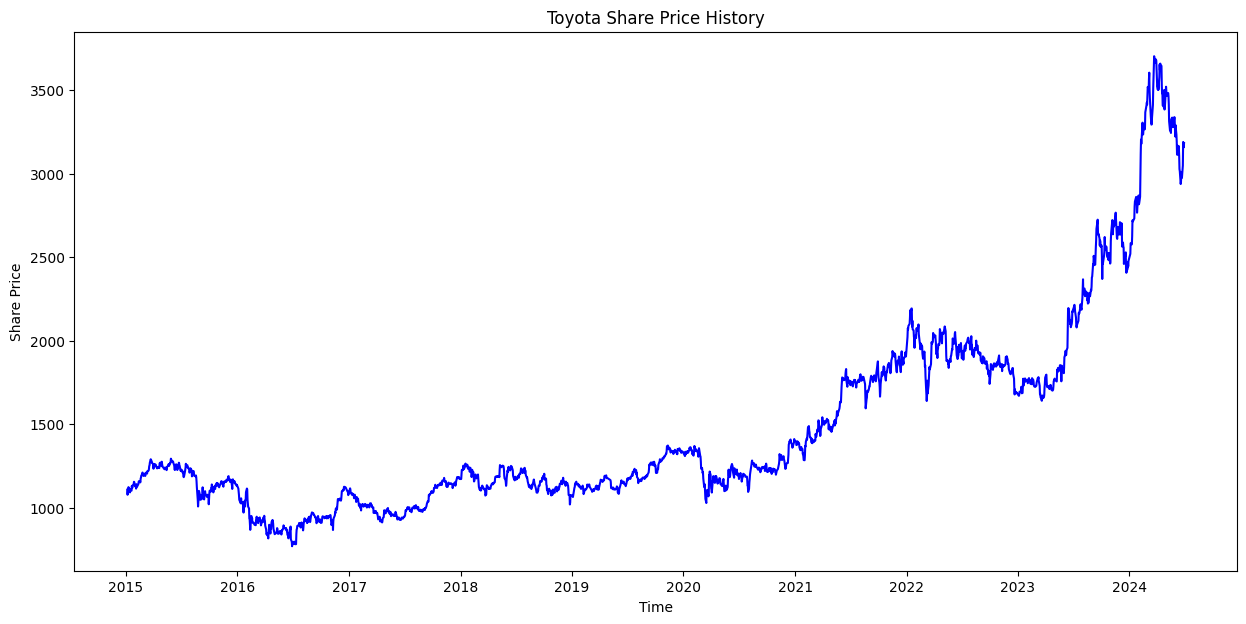

In [5]:
plt.figure(figsize=(15,7))
plt.plot(df['Close'], color='blue', label='Toyota Share Price')
plt.title('Toyota Share Price History')
plt.xlabel('Time')
plt.ylabel('Share Price')

In [6]:
# 2. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.11544972],
       [0.10503831],
       [0.11042003],
       ...,
       [0.81834576],
       [0.81405812],
       [0.82296316]])

Text(0, 0.5, 'Normalized Price')

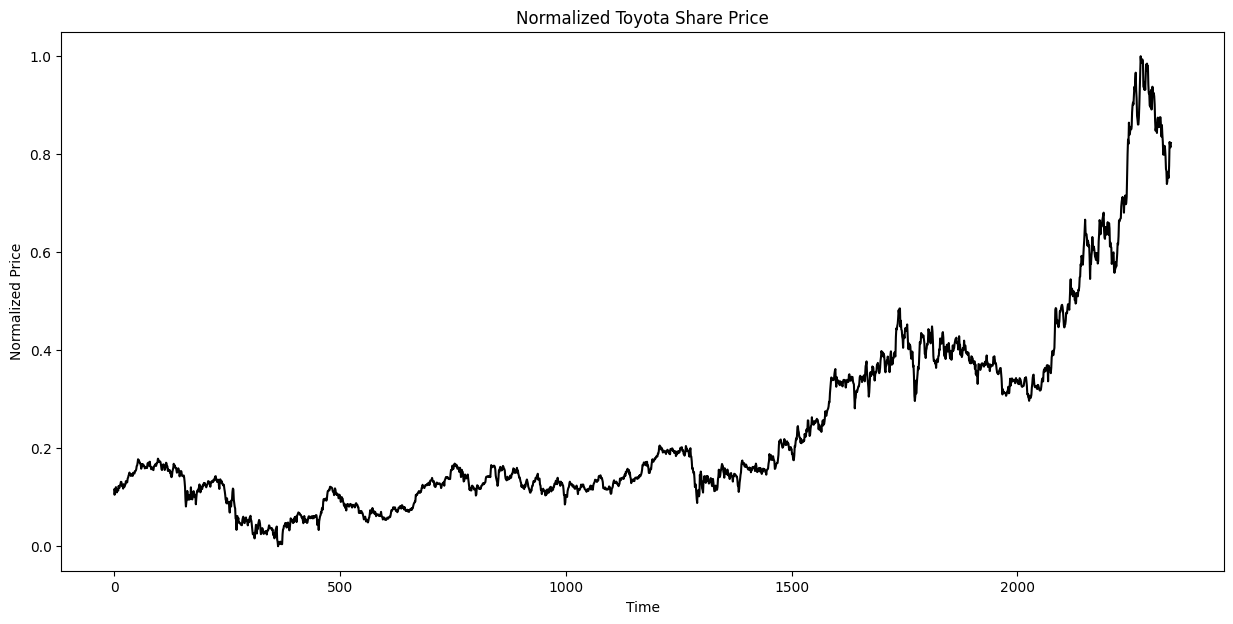

In [7]:
plt.figure(figsize=(15,7))
plt.plot(scaled_data, color='black', label='Normalized Toyota Share Price')
plt.title('Normalized Toyota Share Price')
plt.xlabel('Time')
plt.ylabel('Normalized Price')

In [8]:
# 3. Create sequences for LSTM (use last 60 days to predict next day)
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
# 4. Split into train and test sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1824, 60, 1), (1824,), (457, 60, 1), (457,))

In [11]:
# 5. Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='Nadam', loss='mean_squared_error')

In [12]:
# 6. Train the model
model.fit(X_train, y_train, epochs=15, batch_size=30, verbose=2)

Epoch 1/15
61/61 - 6s - loss: 0.0025 - 6s/epoch - 90ms/step
Epoch 2/15
61/61 - 2s - loss: 6.3023e-04 - 2s/epoch - 32ms/step
Epoch 3/15
61/61 - 2s - loss: 6.4666e-04 - 2s/epoch - 31ms/step
Epoch 4/15
61/61 - 2s - loss: 5.4101e-04 - 2s/epoch - 31ms/step
Epoch 5/15
61/61 - 2s - loss: 4.9669e-04 - 2s/epoch - 31ms/step
Epoch 6/15
61/61 - 2s - loss: 4.8301e-04 - 2s/epoch - 32ms/step
Epoch 7/15
61/61 - 2s - loss: 4.7693e-04 - 2s/epoch - 31ms/step
Epoch 8/15
61/61 - 2s - loss: 4.2058e-04 - 2s/epoch - 31ms/step
Epoch 9/15
61/61 - 2s - loss: 3.8290e-04 - 2s/epoch - 31ms/step
Epoch 10/15
61/61 - 2s - loss: 4.3973e-04 - 2s/epoch - 32ms/step
Epoch 11/15
61/61 - 2s - loss: 3.8095e-04 - 2s/epoch - 34ms/step
Epoch 12/15
61/61 - 2s - loss: 3.5429e-04 - 2s/epoch - 35ms/step
Epoch 13/15
61/61 - 2s - loss: 3.4666e-04 - 2s/epoch - 34ms/step
Epoch 14/15
61/61 - 2s - loss: 3.1810e-04 - 2s/epoch - 34ms/step
Epoch 15/15
61/61 - 2s - loss: 3.2283e-04 - 2s/epoch - 34ms/step


In [13]:
# 7. Predict and inverse transform
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

15/15 [==============================] - 1s 12ms/step


Text(0, 0.5, 'Share Price')

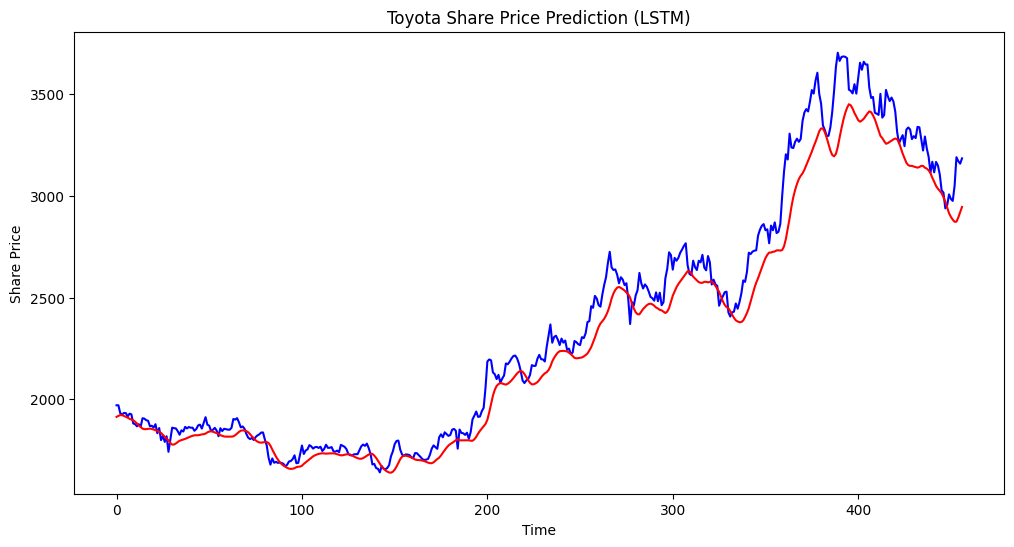

In [14]:
# 8. Plot the results
plt.figure(figsize=(12,6))
plt.plot(real_prices, color='blue', label='Actual Toyota Share Price')
plt.plot(predicted_prices, color='red', label='Predicted Toyota Share Price')
plt.title('Toyota Share Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Share Price')

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Accuracy for normalized (transformed) series
mape_norm = np.mean(np.abs((y_test - predicted.flatten()) / y_test)) * 100
r2_norm = r2_score(y_test, predicted.flatten())

print("Normalized Series Accuracy Metrics:")
print(f"  MAPE: {mape_norm:.2f}%")
print(f"  R2:   {r2_norm:.4f}")

# Accuracy for levels (inverse transformed)
mape_level = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100
r2_level = r2_score(real_prices, predicted_prices)

print("\nLevel Series Accuracy Metrics:")
print(f"  MAPE: {mape_level:.2f}%")
print(f"  R2:   {r2_level:.4f}")

Normalized Series Accuracy Metrics:
  MAPE: 5.09%
  R2:   0.9593

Level Series Accuracy Metrics:
  MAPE: 3.44%
  R2:   0.9593


In [16]:
# 9. Forecasting future prices
# Number of days to forecast
n_forecast = 30
future_predictions = []

# Start with the last sequence from your scaled data
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)


for _ in range(n_forecast):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    # Correctly reshape next_pred and concatenate
    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    last_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_reshaped], axis=1)

# Inverse transform to get actual price predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_prices = scaler.inverse_transform(future_predictions)

print("Next 30 predicted prices:", future_prices.flatten())

1/1 [==============================] - 0s 21ms/step
Next 30 predicted prices: [2970.4045 2968.9    2955.0208 2934.4275 2910.3677 2884.6685 2858.3533
 2831.9915 2805.8977 2780.2441 2755.1216 2730.577  2706.6284 2683.2812
 2660.5283 2638.3596 2616.758  2595.7073 2575.1877 2555.1787 2535.6616
 2516.6147 2498.0193 2479.8562 2462.1077 2444.7554 2427.7832 2411.1755
 2394.9175 2378.995 ]


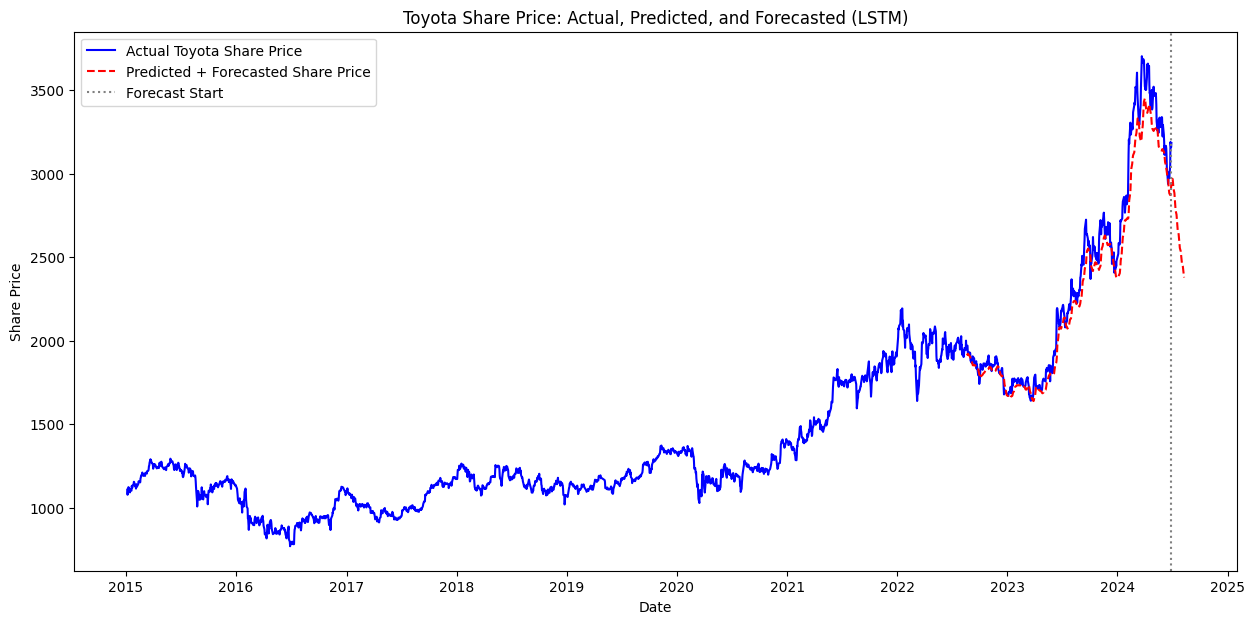

In [17]:
# Combine predicted_prices and future_prices for plotting
all_predicted = np.concatenate([predicted_prices, future_prices])

# Create a new date range for the forecast
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='B')  # 'B' for business days

# Combine the test dates and future dates
test_dates = df.index[-len(predicted_prices):]
all_dates = test_dates.append(future_dates)

# Plot actual, predicted, and forecasted prices
plt.figure(figsize=(15,7))
plt.plot(df.index, df['Close'], color='blue', label='Actual Toyota Share Price')
plt.plot(all_dates, all_predicted, color='red', linestyle='--', label='Predicted + Forecasted Share Price')
plt.axvline(x=test_dates[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title('Toyota Share Price: Actual, Predicted, and Forecasted (LSTM)')
plt.xlabel('Date')
plt.ylabel('Share Price')
plt.legend()
plt.show()